# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

C:\Users\pault\AppData\Local\Temp\ipykernel_14280\4098926419.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("card_credit_fraud.csv", delimiter=";", decimal=",")
df_original = df.copy()
df.head()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


Notre Dataframe ne s'affiche pas correctement lorsqu'on utilise `df.head()`. Après inspection de notre CSV, il semblerait que le problème soit les guillemets entourant chacune des lignes du CSV. Nous pouvons donc retirer ces guillemets et voir ce que cela donne :

## Avant
![image.png](src/trouver_guillemets.png)

## Après
![image2.png](src/csv_sans_guillemet.png)


Notre Dataframe devrait maintenant s'afficher correctement :


In [3]:
df = pd.read_csv("card_credit_fraud.csv", delimiter=";", decimal=",")
df.head()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


# Observation du dataframe

**Taille** : 1008213 lignes par 11 colonnes.

**Présence de valeur null** : Aucune valeur null

**Description de nos features** : 

| Colonne          | Description                                                                                                                |
|------------------|----------------------------------------------------------------------------------------------------------------------------|
| transactionId    | Sert d'index                                                                                                               |
| step             | Heure à laquelle la transaction s'est passée. Minimum = 1 Maximum = 743 ; 743 / 24 ~= 31                                |
| type             | Le type de la transaction. Peut prendre plusieurs valeurs sous forme de chaînes de caractères.  |
| amount           | Le montant de chaque transaction                                                                                          |
| nameOrig         | Numéro de compte de l'émetteur. preprocessing`                                                                                            |
| oldbalanceOrg    | Solde de l'émetteur avant la transaction                                                                                   |
| newbalanceOrig    | Solde de l'émetteur après la transaction                                                                                   |
| nameDest         | Numéro de compte du destinataire.                                                                                           |
| oldbalanceDest   | Solde du destinataire avant la transaction                                                                                 |
| newbalanceDest   | Solde du destinataire après la transaction                                                                                 |
| isFraud          | Notre cible, non fraude = 0 ; fraude = 1                                                                                   |


In [4]:
print("Taille du df : ", df.shape)
print()
print("Présence de valeur nul:", df.isnull().any())
print()
print("Valeur maximum dans step :", df["step"].max())
print()


# On vérifie ici si notre dataset contient des datapoints ayant le même numéro de compte en receveur de TRANSFER et émetteur de CASH_OUT
fraud = df[df["isFraud"] == 1]
fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]
print("Est-ce qu'il y a des lignes de notre df où le destinataire d'un transfer && l'émetteur d'un cash out ont le même numéro de compte ?", fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any())

# On enlève dès maintenant ces deux features
df = df.drop(["nameOrig", "nameDest"], axis=1) 

Taille du df :  (1008213, 11)

Présence de valeur nul: transactionId     False
step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
dtype: bool

Valeur maximum dans step : 743

Est-ce qu'il y a des lignes de notre df où le destinataire d'un transfer && l'émetteur d'un cash out ont le même numéro de compte ? False


## Encodage des valeurs nominales pour pouvoir réaliser une heatmap

In [5]:
df_pre_encoded = df.copy()
df = pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
df.drop(['type'],axis=1,inplace = True)

## Corrélations entre les features

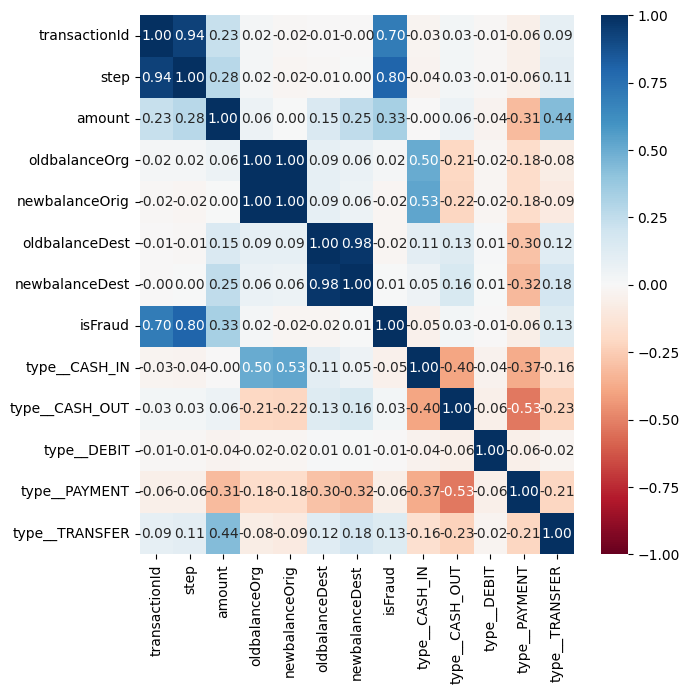

In [6]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(),annot=True, cmap="RdBu" ,fmt='.2f', vmin=-1, vmax= 1)
plt.show()

## Visualisation de la répartition des données

Nous pouvons constater que notre dataset est grandement déséquilibré. 99,2% des data points ne sont pas des fraudes et seulement 0.8% constituent réellement des fraudes. un déséquilibre des classes risqueraient de biaiser l'entraînement des modèles et les prédictions qui en résulteront.

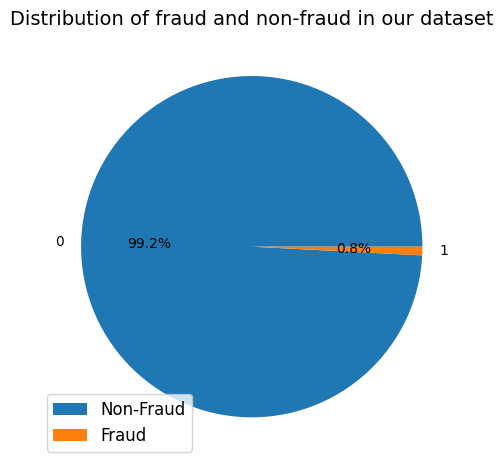

In [7]:
df = df_pre_encoded

# Create the pie chart
plt.pie(df["isFraud"].value_counts(), labels=[0,1], autopct='%1.1f%%')

# Add a title and adjust the font size
plt.title('Distribution of fraud and non-fraud in our dataset', fontsize=14)

# Add a legend and adjust the font size
plt.legend(["Non-Fraud", "Fraud"], fontsize=12)

# Add some padding to the plot
plt.tight_layout()

# Display the plot
plt.show()


## Nettoyage des données

### Drop des colonnes ayant une forte corrélations sans raison apparente

In [8]:
df.drop(["transactionId", "step", "oldbalanceDest"], axis=1, inplace=True)

### Drop des lignes dont le type est différents de "TRANSFER" ou "CASH_OUT"

Les valeurs que peuvent prendre certaines features dans nos datapoints semble optionnel à l'identification d'une fraude.

Comme on peut le constater ci-dessous, les data points qualifiés comme fraudes ont systématiquement comme valeurs pour la colonne ["type"] `TRANSFER` ou `CASH_OUT`. Toutes transactions qui n'est pas d'un de ces deux types ne peux pas être considéré comme une fraude. Nous pouvons donc retirer de notre df tout enregitrement dont la valeurs de ["type"] est différente de `TRANSFER` ou `CASH_OUT`.

In [9]:


df = df.loc[(df['type'] != 'PAYMENT') & (df['type'] != 'CASH_IN') & (df['type'] != 'DEBIT')]
df.reset_index(drop=True, inplace=True) # On reset l'index


print("Quantité de fraude / non fraude dans le df d'origine", df_original["isFraud"].value_counts(), \
      ""
      "Quantité de fraude / non fraude dans le df filtré avec transfer et cash_out : " , df["isFraud"].value_counts())

Quantité de fraude / non fraude dans le df d'origine isFraud
0    1000000
1       8213
Name: count, dtype: int64 Quantité de fraude / non fraude dans le df filtré avec transfer et cash_out :  isFraud
0    444720
1      8213
Name: count, dtype: int64


On retire donc les features cash_in, debit et payment

## Mappage des données et renommage
 

Erreur réalisé : Utilisation de LabelEncoder au lieu de la méthode get_dummies de pandas qui utilises le one hot encoding. le labelEncoder convient pour les données ordinale et le one hot encoding pour les données nominales. 

In [10]:
df.rename({"newbalanceOrig" : "newbalanceOrg"}, inplace=True, axis=1)

df = pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
df.drop(['type'],axis=1,inplace = True)

df = df.reindex(columns=[
                        "amount",
                        "type__CASH_OUT",
                        "type__TRANSFER",
                        "oldbalanceOrg", 
                        "newbalanceOrg", 
                        "newbalanceDest", 
                        "isFraud"
                        ])



C:\Users\pault\AppData\Local\Temp\ipykernel_14280\1633194503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename({"newbalanceOrig" : "newbalanceOrg"}, inplace=True, axis=1)


## Graphique de la nouvelle distribution des données

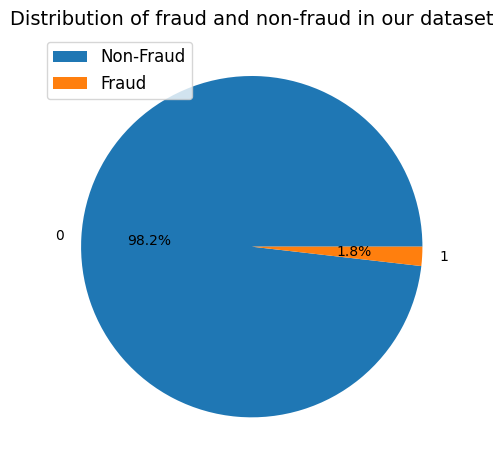

In [11]:
# Create the pie chart
plt.pie(df["isFraud"].value_counts(), labels=[0,1], autopct='%1.1f%%')

# Add a title and adjust the font size
plt.title('Distribution of fraud and non-fraud in our dataset', fontsize=14)

# Add a legend and adjust the font size
plt.legend(["Non-Fraud", "Fraud"], fontsize=12)

# Add some padding to the plot
plt.tight_layout()

# Display the plot
plt.show()

## En résumé

**Taille** : 452933 lignes par 7 colonnes

**Présence de valeur null** : Aucune valeur null

**Description de nos features** : 


| Colonne          | Description                                                                                                                |
|------------------|----------------------------------------------------------------------------------------------------------------------------|
| amount           | Le montant de chaque transaction                                                                                          |
| type__CASH_OUT              | Features crée avec one hot encoding|
| type__TRANSFER              | Features crée avec one hot encoding|
| oldbalanceOrg    | Solde de l'émetteur avant la transaction                                                                                   |
| newbalanceOrig    | Solde de l'émetteur après la transaction                                                                                   |
| newbalanceDest   | Solde du destinataire après la transaction                                                                                 |
| isFraud          | Notre cible, non fraude = 0 ; fraude = 1                                                                                   |

![image.png](src/distribution_class_dataset_filtrer_transfer_cashout.png)

In [12]:
df

,amount,type__CASH_OUT,type__TRANSFER,oldbalanceOrg,newbalanceOrg,newbalanceDest,isFraud
0,181.00,False,True,181.00,0.0,0.00,1
1,181.00,True,False,181.00,0.0,0.00,1
2,229133.94,True,False,15325.00,0.0,51513.44,0
3,215310.30,False,True,705.00,0.0,0.00,0
4,311685.89,False,True,10835.00,0.0,2719172.89,0
...,...,...,...,...,...,...,...
452928,339682.13,True,False,339682.13,0.0,339682.13,1
452929,6311409.28,False,True,6311409.28,0.0,0.00,1
452930,6311409.28,True,False,6311409.28,0.0,6379898.11,1
452931,850002.52,False,True,850002.52,0.0,0.00,1


# Entraînement des modèles

Plan :

Choix des modèles :
- Random Forest
- KNN
- ADABOOST
- Regression logistique



train_test_split

for each models :

    train with no over/undersampling 

    train using Nearmiss
    
    train using smote








In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV

## Train_test_split et features scaling
Pourquoi faire de la normalisation (features scaling) ? -> [Réponse](https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn)

In [14]:

df

,amount,type__CASH_OUT,type__TRANSFER,oldbalanceOrg,newbalanceOrg,newbalanceDest,isFraud
0,181.00,False,True,181.00,0.0,0.00,1
1,181.00,True,False,181.00,0.0,0.00,1
2,229133.94,True,False,15325.00,0.0,51513.44,0
3,215310.30,False,True,705.00,0.0,0.00,0
4,311685.89,False,True,10835.00,0.0,2719172.89,0
...,...,...,...,...,...,...,...
452928,339682.13,True,False,339682.13,0.0,339682.13,1
452929,6311409.28,False,True,6311409.28,0.0,0.00,1
452930,6311409.28,True,False,6311409.28,0.0,6379898.11,1
452931,850002.52,False,True,850002.52,0.0,0.00,1


In [22]:
# features
X = df.drop(["isFraud"], axis=1)

# target
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Features scaling 

from sklearn.preprocessing import StandardScaler

# Création d'une fonction pour mettre à l'échelle notre df
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

col_names = ["amount", "newbalanceOrg", "newbalanceDest"]
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

In [23]:
df

,amount,type__CASH_OUT,type__TRANSFER,oldbalanceOrg,newbalanceOrg,newbalanceDest,isFraud
0,181.00,False,True,181.00,0.0,0.00,1
1,181.00,True,False,181.00,0.0,0.00,1
2,229133.94,True,False,15325.00,0.0,51513.44,0
3,215310.30,False,True,705.00,0.0,0.00,0
4,311685.89,False,True,10835.00,0.0,2719172.89,0
...,...,...,...,...,...,...,...
452928,339682.13,True,False,339682.13,0.0,339682.13,1
452929,6311409.28,False,True,6311409.28,0.0,0.00,1
452930,6311409.28,True,False,6311409.28,0.0,6379898.11,1
452931,850002.52,False,True,850002.52,0.0,0.00,1


## Regression logistique

### Sans over/under sampling

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



# Pour s'assurer que le grid search préserve le pourcentage de chaque classe lors du split
kf = StratifiedKFold(n_splits=5, shuffle=False)

logistic_regression_model = LogisticRegression(random_state=42, n_jobs=-1)
param_logistic_regression = {
    "max_iter" : [100000],
    "penalty" : ["l2","l1"],
    "solver" : ["liblinear"],
    "class_weight" : [None, "balanced"]
    # "tol" : [1e-]  #Decreasing tolerance from 1e-4 by default to 1e-2
}

grid_search = GridSearchCV(logistic_regression_model, param_grid=param_logistic_regression, cv=kf, scoring="recall", refit=True, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\pault\Documents\Python\fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_iter': [100000], 'penalty': ['l2', 'l1'],
                         'solver': ['liblinear']},
             scoring='recall', verbose=2)

In [43]:
import pickle
with open('src/logistic_regression_base.pkl', 'wb') as file:
    pickle.dump(grid_search, file)

In [53]:
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'class_weight': 'balanced', 'max_iter': 100000, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.9948249619482497


In [54]:
score = cross_val_score(logistic_regression_model, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))


KeyboardInterrupt: 

Best parameters: {'max_iter': 100000, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.4919330289193303







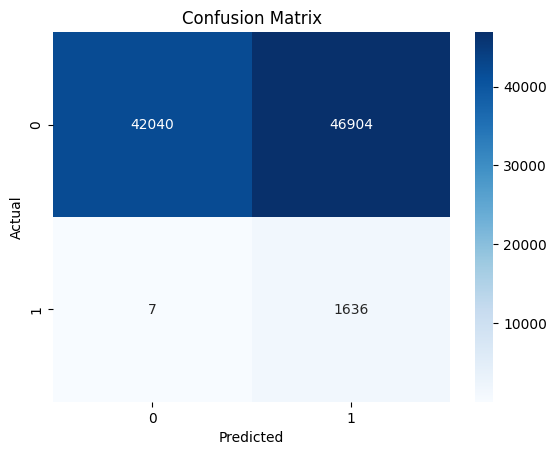

In [55]:

y_pred_over_sampling = grid_search.predict(X_test)
cm_over_sampling = confusion_matrix(y_test, y_pred_over_sampling)

# Create a heatmap using Seaborn
sns.heatmap(cm_over_sampling, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

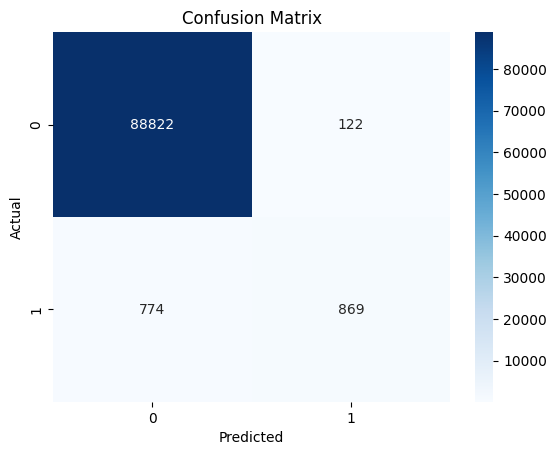

### Avec oversampling (SMOTE)

In [57]:
from imblearn.over_sampling import SMOTE
from collections import Counter


sm = SMOTE(random_state=42, k_neighbors=5, n_jobs=-1) # 

X_smote, y_smote = sm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_smote))

c:\Users\pault\Documents\Python\fraud\.venv\Lib\site-packages\imblearn\over_sampling\_smote\base.py:363: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Original dataset shape: Counter({0: 444720, 1: 8213})
Resample dataset shape: Counter({0: 355776, 1: 355776})


In [67]:
from sklearn.metrics import classification_report, auc, roc_curve
kf = StratifiedKFold(n_splits=5, shuffle=False)

logistic_regression_model = LogisticRegression(random_state=42, n_jobs=-1)
param_logistic_regression = {
    "max_iter" : [100000],
    "penalty" : ["l2","l1"],
    "solver" : ["liblinear"],
    "class_weight" : [None, "balanced"]
    # "tol" : [1e-]  #Decreasing tolerance from 1e-4 by default to 1e-2
}

grid_search = GridSearchCV(logistic_regression_model, param_grid=param_logistic_regression, cv=kf, scoring="f1", refit=True, verbose=2, n_jobs=-1)
grid_search.fit(X_smote, y_smote) 
  

y_pred_no_sampling = grid_search.predict(X_test)
  
# Evaluating model
CM_RF = confusion_matrix(y_test,y_pred_no_sampling)
CR_RF = classification_report(y_test,y_pred_no_sampling)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, y_pred_no_sampling)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

# showing results from Random Forest

for measure in resultsRF:
    print(measure,": \n",resultsRF[measure])

Fitting 5 folds for each of 4 candidates, totalling 20 fits


c:\Users\pault\Documents\Python\fraud\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1216: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  warnings.warn(


Confusion Matrix : 
 [[84712  4232]
 [  302  1341]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     88944
           1       0.24      0.82      0.37      1643

    accuracy                           0.95     90587
   macro avg       0.62      0.88      0.67     90587
weighted avg       0.98      0.95      0.96     90587

Area Under Curve : 
 0.8843046982203961


In [64]:
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'class_weight': None, 'max_iter': 100000, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.9367158286176197


In [65]:
y_pred_no_sampling = grid_search.predict(X_test)
cm_no_sampling = confusion_matrix(y_test, y_pred_no_sampling)
cm_no_sampling

array([[84712,  4232],
       [  302,  1341]], dtype=int64)

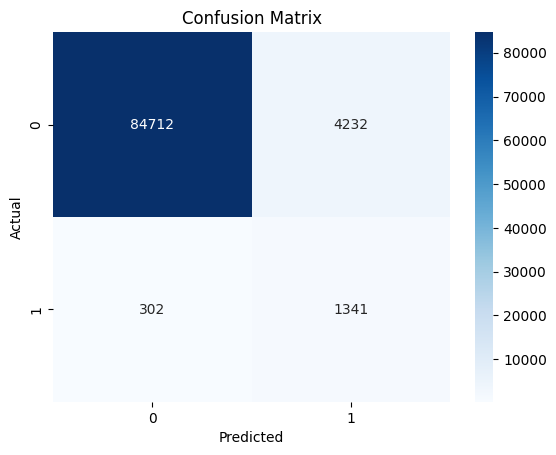

In [66]:
# Create a heatmap using Seaborn
sns.heatmap(cm_no_sampling, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

In [ ]:
import pickle
filename = 'src/modeleregressionlog-penaltyl2-solversaga-tol0d001-recall0d78.pkl'
with open(filename, 'wb') as file:
    pickle.dump(grid_search, file)

"tol" : [1e-2] # Decreasing tolerance from 1e-4 by default to 1e-2 - 2.3m

    Best parameters: {'max_iter': 100000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.01}
    Best score: 0.4888637711057783


    Best parameters: {'max_iter': 100000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
    Best score: 0.7860704381021766

    Matrice :
    [[88541][403]]
    [[433 ][1210]]

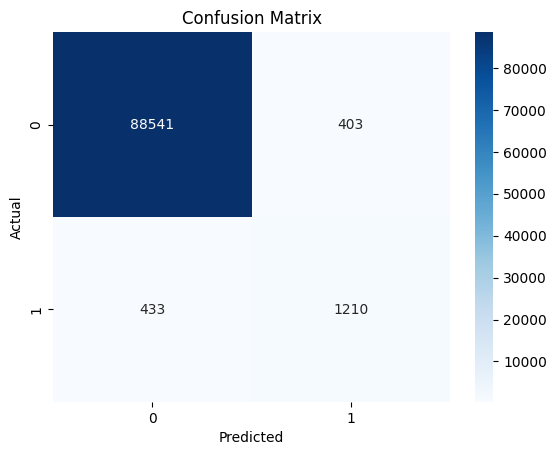




## KNN

### Sans over/under sampling
#### Features scaling

Pourquoi faire de la normalisation ? -> [Réponse](https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

grid_parameters_no_sampling = {"n_neighbors" : [1,2,3], "weights" : ["uniform", "distance"]}

knn_no_sampling = GridSearchCV(KNeighborsClassifier(), grid_parameters_no_sampling, scoring="recall", cv=5, n_jobs=-1)

knn_no_sampling.fit(X_train, y_train)

In [ ]:
score = cross_val_score(logistic_regression_model, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))


### Avec undersampling (Nearmiss)

In [ ]:
from imblearn.under_sampling import NearMiss
from collections import Counter

nm = NearMiss()

X_near_miss, y_near_miss = nm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_near_miss))

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

logistic_regression_model_nearmiss = LogisticRegression(random_state=42)
param_logistic_regression = {
    "max_iter" : [100000],
    "penalty" : ["l2", None],
    "class_weight" : ["balanced", None],
    "solver" : ["saga"]

}

grid_search = GridSearchCV(logistic_regression_model, param_grid=param_logistic_regression, cv=kf, scoring='recall', verbose=2, n_jobs=-1)
grid_search.fit(X_near_miss, y_near_miss)

### Avec oversampling (SMOTE)

In [69]:
from sklearn.neighbors import KNeighborsClassifier

In [76]:



from sklearn.metrics import classification_report, auc, roc_curve
kf = StratifiedKFold(n_splits=5, shuffle=False)

grid_parameters_with_over_sampling = {"n_neighbors" : [3, 5, 7], 
                                      "weights" : ["uniform","distance"], 
                                      "algorithm" : ["ball_tree", "kd_tree", "brute"], 
                                      "leaf_size" : [15,30,50,]}

knn_over_sampling = KNeighborsClassifier(n_jobs=-1)

grid_search = GridSearchCV(knn_over_sampling, param_grid=grid_parameters_with_over_sampling, cv=kf, scoring="recall", refit=True, verbose=2, n_jobs=-1)
grid_search.fit(X_smote, y_smote) 
  

y_pred_no_sampling = grid_search.predict(X_test)
  
# Evaluating model
CM_RF = confusion_matrix(y_test,y_pred_no_sampling)
CR_RF = classification_report(y_test,y_pred_no_sampling)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, y_pred_no_sampling)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

# showing results from Random Forest

for measure in resultsRF:
    print(measure   ,": \n",resultsRF[measure])


Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\pault\Documents\Python\fraud\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
66 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pault\Documents\Python\fraud\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pault\Documents\Python\fraud\.venv\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\pault\Documents\Python\fraud\.venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    valid

Confusion Matrix : 
 [[79364  9580]
 [  286  1357]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.89      0.94     88944
           1       0.12      0.83      0.22      1643

    accuracy                           0.89     90587
   macro avg       0.56      0.86      0.58     90587
weighted avg       0.98      0.89      0.93     90587

Area Under Curve : 
 0.8591099796276035


In [81]:
with open('src/KNN_SMOTE_V1.pkl', 'wb') as file:
    pickle.dump(grid_search, file)

In [80]:
'''
KNN SMOTE V1 :
grid_parameters_with_over_sampling = {"n_neighbors" : [3, 5, 7], 
                                      "weights" : ["unifmorm","distance"], 
                                      "algorithm" : ["ball_tree", "kd_tree", "brute"], 
                                      "leaf_size" : [15,30,50,]}
               
               KNN SMOTE V2                       
grid_parameters_with_over_sampling = {"n_neighbors" : [7, 15, 20], 
                                      "algorithm" : ["ball_tree"], 
                                      "leaf_size" : [3,7,15]}                                      
                                      
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 15, 'n_neighbors': 7, 'weights': 'distance'}
Best score: 0.918201346312936


'''

print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 15, 'n_neighbors': 7, 'weights': 'distance'}
Best score: 0.918201346312936


1er essai : grid_parameters_with_over_sampling = {"n_neighbors" : [3, 5, 7], "leaf_size" : [20]} 2.54m 
    Best parameters: {'leaf_size': 20, 'n_neighbors': 5}
    Best score: 0.8954651302345649

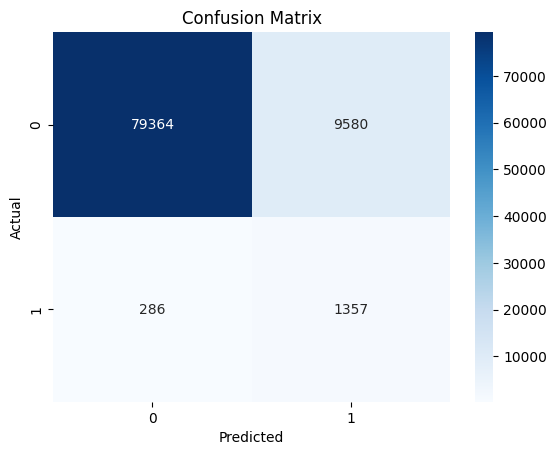

In [78]:


cm_over_sampling = confusion_matrix(y_test, y_pred_no_sampling)

# Create a heatmap using Seaborn
sns.heatmap(cm_over_sampling, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

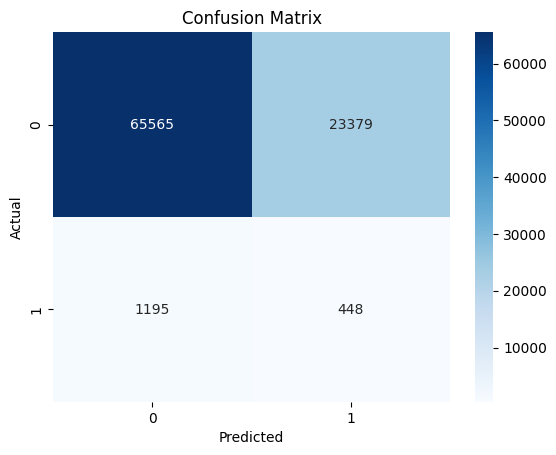